In [108]:
# load some packages
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial.distance import squareform
import random
import oatpy as oat
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
import sys
import os
from scipy.interpolate import interp1d
import community as community_louvain
import null_model_or_new_data as nmnd


# configuration
PROJECT_PATH = "~/Dropbox/MACALESTER_SUMMER_2023/" # edit this path for your machine!
DATA_PATH = "/Users/luohanzhi/Desktop/大三上/Summer research/MACALESTER_SUMMER_2024 (1)/data/applied_mathematics_piloting/"
DATA_PATH2 = "/Users/luohanzhi/Desktop/大三上/Summer research/concepts/"
CONCEPT_FILE = "articles_category_for_2l_abstracts_concepts_processed_v1_EX_102.csv.gz" # Applied Mathematics
ATTRIBUTES_FILE = "dimensions_2021_09_01_articles_category_for_2l_code_102.csv.gz" # Applied Mathematics
ZOOL_FILE = "concepts_Visual Arts and Crafts_1905.csv.gz"

In [3]:
def persistance_image(barcode: pd.DataFrame,
                      dim: int | list[int] | None = None,
                      sigma: float = 0.1,
                      res: int = 20,
                      weight_func: callable = lambda x, y: y,
                      return_vec: bool = False
                      ) -> np.ndarray | dict[int: np.ndarray]:
    '''
    Makes a persitance image from a homology dataframe

    The coordinates for the peristance image are normalized within [0, 1]. The function
    treats features that never die as having a death coordiate of 1, so features that die
    in the last period aren't distingushed from features that never die. If you want to
    plot the perstance image, use
    ```
        import matplotlib.pyplot as plt

        x = np.linspace(0, 1, resolution)
        y = np.linspace(0, 1, resolution)
        x, y = np.meshgrid(x, y)
        res = persistance_image(
                homology,
                res=resolution,
                return_vec=False # return_vec defaults false, so you can leave it out, but not make it true
            )

        plt.axis('equal')
        plt.pcolormesh(x, y, res[dimension])
    ```

    Args:
        `barcode` (Dataframe): A dataframe with homological features of the simplicial
        complex. Should have a "birth" column for when features were born, a "death"
        column with when features died, and a "dimension" column with the feature
        dimension
        `dim` (int | list[int] | None): The dimensions to create a persistance image for.
        If an int, creates an image for only that dimension. If a list (or other iterable),
        creates an image for all the dimensions in the list. If None, creates an image for
        all unique dimensions in `barcode`.
        Default None.
        `sigma` (float): Standard deviation of the Gaussians used for the persistance
        image. Default 0.1
        `res` (int): Resolution of the returned peristance image. Default 20
        `weight_func` (callable): Function in f(x, y) form that takes the birth, lifetime
        coordinates of the feature and returns the weight of the feature in the gaussians.
        f(x, 0) should be 0 for all x values. Defaults to linear scaling based only on the
        lifetime 
        `return_vec` (bool): Whether to return an matrix or vector. If True, returns a
        vector. Typically, a matrix will work better to visualize the persistance image but
         a vector is better to compare two barcodes. Default False
    
    Returns:
        `persistance_images` (list[np.ndarray]): A list of matricies of vectors (depening on
        the return_vec value) with the peristance images. Each value in the list corresponds
        to a different dimension, with the ith value corresponding to the persistance image
        for i dimensional features
    '''
    # we want it in a list
    if isinstance(dim, int):
        dim = [dim]

    # maximum lifetime
    # we want to normalize everything to [0, 1], this is the value we divide by to do that
    max_lifetime = oat.barcode.max_finite_value(barcode['death'])

    # points on the persistance diagram
    persistance_diagram = pd.DataFrame()
    persistance_diagram['dimension'] = barcode.reset_index(drop=True)['dimension'] # Each unique dimension will be a different diagram
    persistance_diagram['birth'] = barcode.reset_index(drop=True)['birth'] / max_lifetime # normalize birth times
    persistance_diagram['death'] = barcode.reset_index(drop=True)['death'] / max_lifetime # normalize death times
    persistance_diagram.loc[persistance_diagram['death'] == np.inf, 'death'] = 1 # set inf death times to the max (1)
    persistance_diagram['lifetime'] = persistance_diagram['death'] - persistance_diagram['birth'] # birth, lifetime create persistance image basis
    persistance_diagram['weight'] = weight_func(persistance_diagram['birth'], persistance_diagram['lifetime'])

    # remove rows after max dimension
    if dim is not None:
        persistance_diagram = persistance_diagram[persistance_diagram['dimension'].isin(dim)]
    else:
        dim = list(persistance_diagram['dimension'].unique()) # loop over dim later, needs to be defined

    # matricies to calculate peristance image
    # x, y coordinate of every entry i, j in the persistance image is x[i, j], y[i, j]
    x = np.linspace(0, 1, res)
    y = np.linspace(0, 1, res)
    x, y = np.meshgrid(x, y)

    # apply gaussians and get images
    var = 2 * sigma**2 # actualy 2*variance but this is what we use so
    persistance_images = []
    for d in dim: # create a different persisance image for each dimension
        d_persistance_diagram = persistance_diagram[persistance_diagram['dimension'] == d] # peristance diagram fo dimension
        gaussians = [w * np.exp(-((x-b)**2 + (y-l)**2)/var) for w, b, l in zip(d_persistance_diagram['weight'], d_persistance_diagram['birth'], d_persistance_diagram['lifetime'])]
        # use gaussian formula weighting by the calculated weight and using the point location for all x and y in the matrix
        persistance_image = np.full((res, res), 0) + sum(gaussians) # full makes sure we have all 0s if dimension has no features
        persistance_images.append(persistance_image)
    
    # make a vector (if we should)
    if return_vec:
        persistance_images = [np.reshape(pi, -1) for pi in persistance_images]
    
    # reshape returned value
    if len(persistance_images) == 1: # take it out of the list if there's only one thing
        persistance_images = persistance_images[0]
    else: # make a dict with the dim values
        persistance_images = {d: pi for d, pi in zip(dim, persistance_images)}

    return persistance_images


def format_ripser_output(ripser_res: dict[str: np.ndarray]
                         ) -> pd.DataFrame:
    '''
    Takes the results from a ripser function and formats it as a dataframe
    to be used to compare to other barcodes.

    Args:
        `ripser_res` (dict[str: np.ndarray]): The results from the `ripser`
        function within the `ripser` library
    
    Returns:
        `res` (Dataframe): Formatted and sorted dataframe containing the
        barcode information in "dimension", "birth", and "death" columns
    '''
    dimension = [] # feature dimention
    birth = [] # birth time
    death = [] # death time

    for dim, bc in enumerate(ripser_res['dgms']):
        for b, d in bc:
            dimension.append(dim)
            birth.append(b)
            death.append(d)

    # collect results
    res = pd.DataFrame(data={'dimension': dimension, 'birth': birth, 'death': death})
    res = res.sort_values(['dimension', 'birth', 'death'], ignore_index=True)
    return res

def persistance_image_distance(barcode_1: pd.DataFrame,
                               barcode_2: pd.DataFrame,
                               dim: int | None = None,
                               norm: float = 2.,
                               **kwargs: dict[str: any]
                               ) -> float:
    '''
    Calculates the distance between two barcodes using peristance images.

    Args:
        `barcode_1` (Dataframe): Dataframe with the information for the first barcode.
        Should have "birth" and "death" columns
        `barcode_2` (Dataframe): Dataframe with the information for the second barcode.
        Should have "birth" and "death" columns
        `dim` (int | None): The dimension to look at if an int. Doesn't filter dimensions
        at all otherwise. Will throw an error if None and the barcodes haven't already
        been filtered to only a single dimension.
        `norm` (float): The norm to calculate distance between persistance images using.
        Should be >= 1. Default 2
        `**kwargs` (dict[str: any]): Options passed to the `persistance_image` function
    
    Returns
        `dist` (Float): The Persistance Image Distance between the two barcodes
    '''
    barcode_1, barcode_2 = barcode_1.copy(), barcode_2.copy() # don't change the dataframes

    # filter dimension
    if dim is not None:
        barcode_1 = barcode_1[barcode_1['dimension'] == dim]
        barcode_2 = barcode_2[barcode_2['dimension'] == dim]

    # setup
    persistance_image_1 = persistance_image(barcode_1, return_vec=True, **kwargs)
    persistance_image_2 = persistance_image(barcode_2, return_vec=True, **kwargs)
    
    # distance function
    if norm == np.inf:
        dist = np.max(np.abs(persistance_image_1 - persistance_image_2))
    else:
        if type(persistance_image_1) == dict:
            vector_1= np.concatenate([persistance_image_1[key] for key in persistance_image_1])
        else:
            vector_1 = persistance_image_1

        if type(persistance_image_2) == dict:
            vector_2 = np.concatenate([persistance_image_2[key] for key in persistance_image_2])
        else:
            vector_2 = persistance_image_2

        n = np.abs(len(vector_1)-len(vector_2))

        zeros = [0] * n

        if len(vector_1)>len(vector_2):
            vector_2 = np.concatenate((vector_2, zeros))

        if len(vector_1)<len(vector_2):
            vector_1 = np.concatenate((vector_1, zeros))

        dist = (np.sum(np.abs(vector_1 - vector_2)**norm))**(1/norm)
        
    return dist

def barcode_distance_matrix(barcodes: list[pd.DataFrame],
                            dim: int | None = None,
                            labels: list[str] | None = None,
                            asymetric: bool = False,
                            calc_diagnal: bool = False,
                            **kwargs: dict[str: any]
                            ) -> pd.DataFrame:
    '''
    Creates a matrix of distances between barcodes based on an inputted distance function

    Args:
        `barcodes` (list[Dataframe]): A list of barcodes for find distances between
        `barcode_distance_func` (callable): A function that finds the distance between
        barcodes
        `dim` (int | None): The dimension to look at if an int. Doesn't filter dimension at
        all if None. Default None
        `labels` (list[str] | None): A list of labels for the distance matrix. If None, uses
        default pandas labeling (numbers 0-n)
        `asymetric` (bool): Whether to calcaulte the lower triangle of the distance matrix.
        If this is False, it assumes the distance matrix will be symetric (so the distance
        from barcode 1 to barcode 2 is that same as the distance from barcode 2 to barcode 1)
        and fills in the lower triangle with the values calculated in the upper triangle. If
        True, it calculates all entries, except those on the diagnal. Default False
        `calc_diagnal` (bool): Whether to calcuate entries along the diagnal. Otherwise,
        assumes it's 0. Generally, this should be False. Default False
        `**kwargs` (dict[str: any]): Options passed to the `barcode_distance_func` function
    
    Returns
        `dist_matrix` (pd.Dataframe): A matrix of distances between barcodes
    '''
    # filter dimension
    if dim is not None:
        for i, b in enumerate(barcodes):
            b = b[b['dimension'] == dim]
            barcodes[i] = b
    
    # setup distance
    n = len(barcodes)
    dist_matrix = pd.DataFrame(data=np.full((n, n), 0.), index=labels, columns=labels)

    # calculate distances
    for i in range(n):
        if asymetric:
            for j in range(i): # lower triangle
                dist_matrix.iloc[i, j] = persistance_image_distance(barcodes[i], barcodes[j], **kwargs)

        if calc_diagnal: # diagnal
            dist_matrix.iloc[i, i] = persistance_image_distance(barcodes[i], barcodes[i], **kwargs)

        for j in range(i+1, n): # upper triangle
            dist_matrix.iloc[i, j] = persistance_image_distance(barcodes[i], barcodes[j], **kwargs)

    # fill in lower triangle
    if not asymetric:
        dist_matrix += dist_matrix.T

    return dist_matrix


def barcode_distance_vector(barcodes: list[pd.DataFrame],
                            dim: int | None = None,
                            labels: list[str] | None = None,
                            **kwargs: dict[str: any]
                            ) -> pd.DataFrame:
    '''
    Creates a matrix of distances between barcodes based on an inputted distance function

    Args:
        `barcodes` (list[Dataframe]): A list of barcodes for find distances between
        `barcode_distance_func` (callable): A function that finds the distance between
        barcodes
        `dim` (int | None): The dimension to look at if an int. Doesn't filter dimension at
        all if None. Default None
        `labels` (list[str] | None): A list of labels for the distance matrix. If None, uses
        default pandas labeling (numbers 0-n)
        `asymetric` (bool): Whether to calcaulte the lower triangle of the distance matrix.
        If this is False, it assumes the distance matrix will be symetric (so the distance
        from barcode 1 to barcode 2 is that same as the distance from barcode 2 to barcode 1)
        and fills in the lower triangle with the values calculated in the upper triangle. If
        True, it calculates all entries, except those on the diagnal. Default False
        `calc_diagnal` (bool): Whether to calcuate entries along the diagnal. Otherwise,
        assumes it's 0. Generally, this should be False. Default False
        `**kwargs` (dict[str: any]): Options passed to the `barcode_distance_func` function
    
    Returns
        `dist_matrix` (pd.Dataframe): A matrix of distances between barcodes
    '''
    # filter dimension
    if dim is not None:
        for i, b in enumerate(barcodes):
            b = b[b['dimension'] == dim]
            barcodes[i] = b
    
    # setup distance vector
    n = len(barcodes)
    dist_vector = pd.DataFrame(data=np.full((1, n), 0.), index=labels, columns=labels)

    # calculate distances
    for i in range(n):
        dist_vector.iloc[0, i] = persistance_image_distance(barcodes[0], barcodes[i], **kwargs)
    
    return dist_vector



In [5]:
def local_edge_swap(graph, k, num_swaps_per_node):
    "k is the range of the neighborhood, num_swaps_per_node is the number one node swap, node_persent is the persent of nodes that swap"
    # Make a copy of the original graph
    H = graph.copy()

    
    # Iterate through each node in the graph
    for node in H.nodes:
        # Get the k-neighborhood of the node
        k_neighborhood = nx.ego_graph(H, node, radius=k)
        
        # Get the edges within the k-neighborhood
        edges = list(k_neighborhood.edges())
        
        # Perform edge swaps within the k-neighborhood
        for _ in range(num_swaps_per_node):
            if len(edges) < 2:
                break
            # Choose two random edges to swap
            edge1, edge2 = random.sample(edges, 2)
            (u1, v1) = edge1
            (u2, v2) = edge2
            
            # Avoid creating self-loops or duplicate edges
            if len({u1, v1, u2, v2}) == 4:
                if not H.has_edge(u1, v2) and not H.has_edge(u2, v1):
                    # Perform the edge swap
                    H.remove_edge(u1, v1)
                    H.remove_edge(u2, v2)
                    H.add_edge(u1, v2)
                    H.add_edge(u2, v1)
                    # Update the edges list
                    edges.remove(edge1)
                    edges.remove(edge2)
                    edges.append((u1, v2))
                    edges.append((u2, v1))
                    
    return H

def local_swap_barcode(
        l: int,
        dim: int, 
        k: int, 
        n: int, 
        G_list: list, 
        mylist: list):


    for i in range(l):
        G = G_list[i]

        num_swaps_per_node = n
        
        # Get the local edge swap graph
        G_l = local_edge_swap(G, k, num_swaps_per_node)
        print(i)

        dist_matrix_G_l = nx.adjacency_matrix(G_l, weight='weight')

        G_l_res = ripser(dist_matrix_G_l, maxdim=dim, distance_matrix=True)
        G_l_res = format_ripser_output(G_l_res)

        mylist.append(G_l_res)

    return mylist

In [6]:
# load the data
article_concept_df = pd.read_csv(DATA_PATH + CONCEPT_FILE)
article_concept_df = article_concept_df[article_concept_df['mean'] > 0.7] # filter relevance   
article_concept_df = article_concept_df[article_concept_df['year'] > 1920] # filter relevance   

In [7]:
article_concept_df[article_concept_df.year<1920]

,article_id,category_for_2l_code,year,concept,mean,size,concept_no,dfreq_in_category_for_2l,dfreq_in_category_for_2l_year


# Get the real data for concepts 40-80

In [8]:
mylist =[]
weight_count = {}
num = 10
low = 40
up = 80

#lists = nmnd.data_barcode(num, 3, low, up, article_concept_df, weight_count, mylist)

# low = 41
# up = 51

lists1 = nmnd.data_barcode_one(num, 3, low, up, article_concept_df, weight_count, mylist)

lists = lists1.copy()

mylist_o = lists[0]
weight_count = lists[1]
G_list = lists[2]

G = G_list[0]
nodd = G.number_of_nodes()
edgg = G.number_of_edges()

Graph with 1149 nodes and 13021 edges


# Get the real data for concepts 30-60

In [9]:
mylist =[]
weight_count = {}
num = 10
low = 30
up = 60

lists2 = nmnd.data_barcode_one(num, 3, low, up, article_concept_df, weight_count, mylist)

mylist_o2 = lists2[0]
weight_count2 = lists2[1]
G_list = lists2[2]

Graph with 1614 nodes and 14853 edges


# Get the real data for concepts 20-40

In [10]:
mylist =[]
weight_count = {}
num = 10
low = 20
up = 40

lists3 = nmnd.data_barcode_one(num, 3, low, up, article_concept_df, weight_count, mylist)

Graph with 2623 nodes and 18496 edges


# Get the real data for concepts 11-20

In [11]:
mylist =[]
weight_count = {}
num = 10
low = 11
up = 20

lists4 = nmnd.data_barcode_one(num, 3, low, up, article_concept_df, weight_count, mylist)

Graph with 4785 nodes and 17456 edges


In [12]:
mylist = mylist_o.copy()

In [13]:
#mylist =local_swap_barcode(num, 3, 3, 2, G_list, mylist)
#mylist = local_swap_barcode(num, 3, 100, 8, G_list, mylist)
# #mylist = local_swap_barcode(num, 3, 30, 6, G_list, mylist)

In [14]:
# mylist = nmnd.double_swap_barcode(num, 3, int(edgg/5), int(edgg/5)*5, G_list, mylist)
# mylist = nmnd.double_swap_barcode(num, 3, int(edgg/2), int(edgg/2)*5, G_list, mylist)
# mylist = nmnd.double_swap_barcode(num, 3, edgg, edgg*5, G_list, mylist)
# mylist = nmnd.double_swap_barcode(num, 3, edgg*2, edgg*10, G_list, mylist)

# Find distribution for weight

In [ ]:
sorted_weights = sorted(weight_count.items())

# Separate the weights and their counts for plotting
weights, counts = zip(*sorted_weights)

# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(weights, counts, marker='o', linestyle='-')
plt.xlabel('Edge Weight')
plt.ylabel('Count')
plt.title('Distribution of Edge Weights')
plt.grid(True)
plt.show()

In [16]:
import math

print(counts)
print(weights)

log_weights = [math.log(num) for num in weights]
print(log_weights)

log_counts = [math.log(num) for num in counts]
print(log_counts)

(3, 1, 2, 1, 1, 4, 18, 5, 7, 14, 12, 39, 14, 23, 22, 31, 21, 22, 19, 49, 50, 38, 44, 32, 48, 52, 36, 75, 55, 85, 69, 70, 73, 96, 74, 135, 119, 121, 115, 172, 166, 189, 190, 191, 222, 258, 237, 330, 357, 395, 475, 564, 535, 569, 712, 827, 913, 890, 995, 995, 1301, 1402, 1668, 1208)
(0.16831683168316833, 0.26732673267326734, 0.38613861386138615, 0.39603960396039606, 0.40594059405940597, 0.42574257425742573, 0.43564356435643564, 0.44554455445544555, 0.45544554455445546, 0.46534653465346537, 0.4752475247524752, 0.48514851485148514, 0.49504950495049505, 0.504950495049505, 0.5148514851485149, 0.5247524752475248, 0.5346534653465347, 0.5445544554455446, 0.5544554455445545, 0.5643564356435643, 0.5742574257425742, 0.5841584158415841, 0.594059405940594, 0.6039603960396039, 0.6138613861386139, 0.6237623762376238, 0.6336633663366337, 0.6435643564356436, 0.6534653465346535, 0.6633663366336634, 0.6732673267326733, 0.6831683168316832, 0.693069306930693, 0.7029702970297029, 0.7128712871287128, 0.722772

In [17]:
def sample_from_cdf(weight_count, n):
    "n is the number of edges"
    sorted_weights = sorted(weight_count.items())

    # Separate the weights and their counts for plotting
    weights, counts = zip(*sorted_weights)

    x = weights
    y = counts / np.sum(counts)
    cdf = np.cumsum(y)

    inverse_cdf = interp1d(cdf, x, bounds_error=False, fill_value=(x[0], x[-1]))

    random_values = np.random.rand(n)

    samples = inverse_cdf(random_values)

    return samples


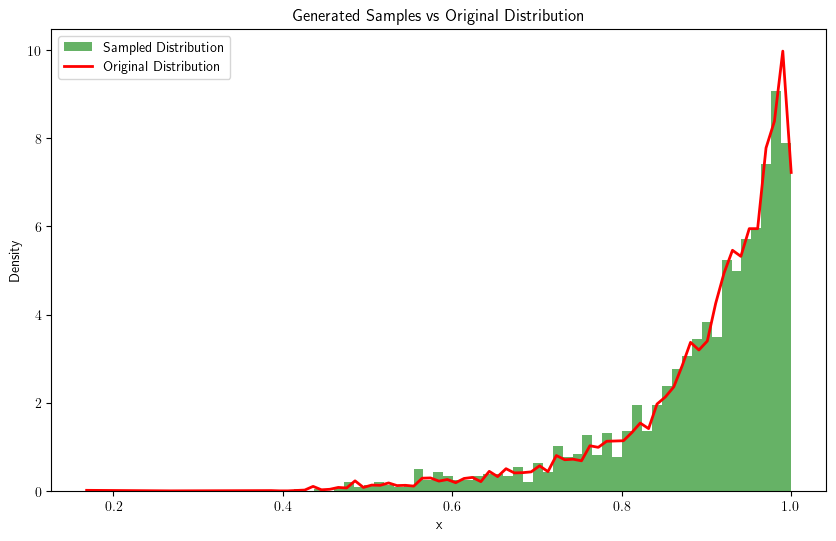

In [ ]:
x = weights
y = counts / np.sum(counts)
cdf = np.cumsum(y)

inverse_cdf = interp1d(cdf, x, bounds_error=False, fill_value=(x[0], x[-1]))

# Number of samples you want to generate
num_samples = 2000

# Generate uniform random numbers between 0 and 1
random_values = np.random.rand(num_samples)

# Use the inverse CDF to get samples from the desired distribution
samples = inverse_cdf(random_values)

# Plot the original data and the generated samples
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g', label='Sampled Distribution')

# Plot the original x and y data for comparison
plt.plot(x, y / np.trapz(y, x), 'r-', lw=2, label='Original Distribution')

plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.title('Generated Samples vs Original Distribution')
plt.show()

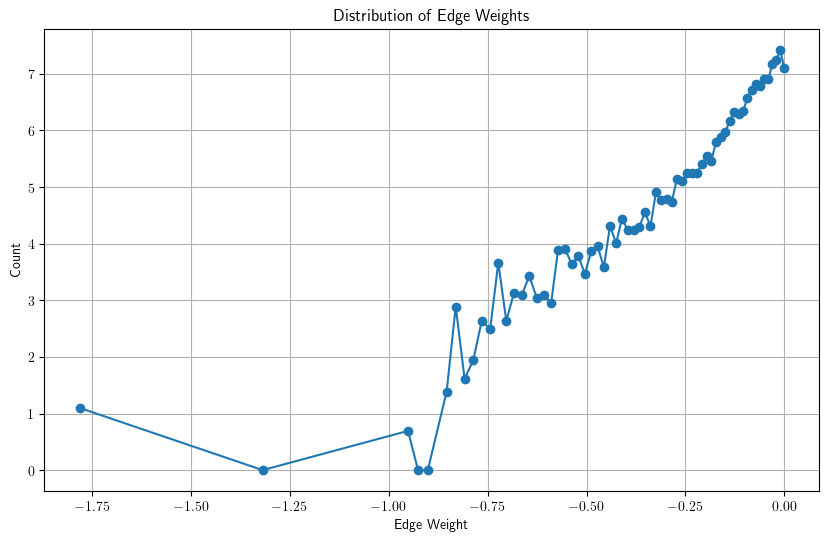

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(log_weights, log_counts, marker='o', linestyle='-')
plt.xlabel('Edge Weight')
plt.ylabel('Count')
plt.title('Distribution of Edge Weights')
plt.grid(True)
plt.show()

In [ ]:
# weights = np.array(list(weight_count.keys()))
# counts = np.array(list(weight_count.values()))

# # Scatter plot of the data
# plt.figure(figsize=(10, 6))
# plt.scatter(weights, counts, label='Data', color='blue')

# Define a function to fit, e.g., a polynomial of degree 2
def polynomial(x, a, b, c, d, e, f):
    return a * x**5 + b * x**4 + c * x**3 + d * x**2 + e * x + f

# # Fit the polynomial to the data using least squares
params, _ = curve_fit(polynomial, weights, counts)

# # Generate fitted data
# fitted_counts = polynomial(weights, *params)

# # Plot the fitted function
# plt.plot(weights, fitted_counts, label='Fitted Function', color='red')

# # Add labels and title
# plt.xlabel('Edge Weight')
# plt.ylabel('Count')
# plt.title('Distribution of Edge Weights with Fitted Function')
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
def create_polynomial(a, b, c, d, e, f):
    # Convert coefficients to integers by taking only the integer part
    a = int(a)
    b = int(b)
    c = int(c)
    d = int(d)
    e = int(e)
    f = int(f)

    # Define the polynomial function
    def polynomial(x):
        return a * x**5 + b * x**4 + c * x**3 + d * x**2 + e * x + f
    
    return polynomial

f = create_polynomial(*params)

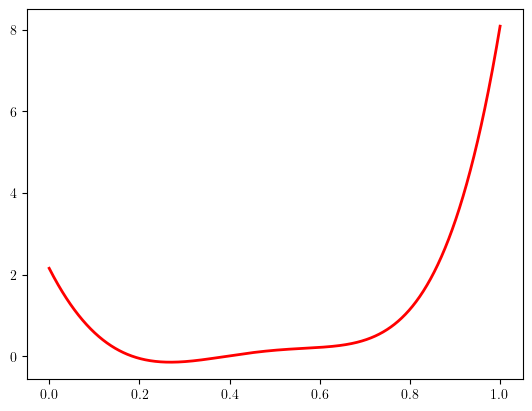

In [ ]:
x_plot = np.linspace(0, 1, 1000)
y_plot = f(x_plot)/ np.trapz(f(x_plot), x_plot)
plt.plot(x_plot, y_plot, 'r-', lw=2, label='Original Function')

In [ ]:
# Define the function
def f(x):
    return 28734 * x**5 - 58452 * x**4 + 44040 * x**3 - 14361 * x**2 + 1827 * x - 50

done
done


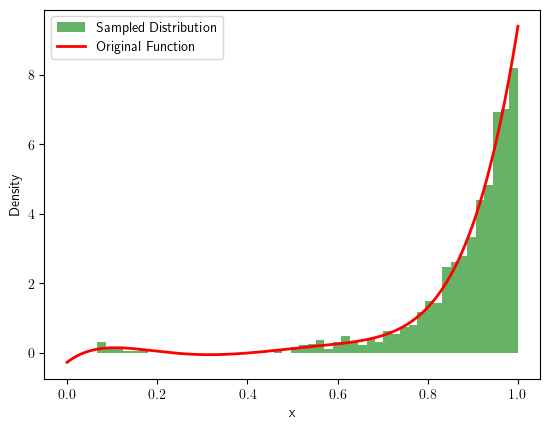

In [ ]:
# Find the maximum value of the function in the range [0, 1]
x_values = np.linspace(0, 1, 100)
y_values = f(x_values)
f_max = np.max(y_values)

# Rejection sampling function
def rejection_sampling(f, f_max, num_samples, range_min=0, range_max=1):
    samples = []
    while len(samples) < num_samples:
        x = np.random.uniform(range_min, range_max)
        y = np.random.uniform(0, f_max)
        if y <= f(x):
            samples.append(x)
    return np.array(samples)

print("done")

# Number of samples you want to generate
num_samples = 1000

# Generate the samples
samples = rejection_sampling(f, f_max, num_samples)

print("done")

# Plot the distribution of the samples
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g', label='Sampled Distribution')

# Plot the original function for comparison
x_plot = np.linspace(0, 1, 1000)
y_plot = f(x_plot) / np.trapz(f(x_plot), x_plot)  # Normalizing the function
plt.plot(x_plot, y_plot, 'r-', lw=2, label='Original Function')

plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()


# Functions for diference random graphs

In [18]:
def watts_strogatz_barcode(
        l: int, 
        n: int,
        m: float,
        k: int, 
        dim: int, 
        mylist: list, 
        weight: str,
        f: any, 
        f_max: float, 
        weight_count: dict | None = None,
        r_graph: bool | None = None):
    '''Making a  list of barcode for l number of watts_strogatz_graph
        l: how many times, n: number of nodes, 
        n: number of nodes
        m:the upper bound for p, (0.15 for 5000 nodes)
        k: the number of edge each node has at beginning
        dim: the dimension for the persistant diagram
        mylist: original list
        weight: weighting method'''

    graph_set = []

    for i in range(l):
        #Choose randome p and k
        p=np.random.uniform(0, m)
        #k=2
        #np.random.choice([2,4,6,8])


        #Get the graph G
        G = nx.watts_strogatz_graph(n, k, p, seed=None)

     #Weight edges
        if weight == "pdf":
            for (u, v) in G.edges():
                G.edges[u, v]['weight'] = float(rejection_sampling(f, f_max, 1))

        if weight == "cdf":
            num_of_edge = G.number_of_edges()
            n_edge = 0
            weight_for_edges = sample_from_cdf(weight_count, num_of_edge)
            for (u, v) in G.edges():
                G.edges[u, v]['weight'] = weight_for_edges[n_edge]
                n_edge = n_edge + 1
        
        if weight == "random":
            for (u, v) in G.edges():
                G.edges[u, v]['weight'] = np.random.uniform(0, 1)

        if r_graph:
            graph_set.append(G)


     # Find the distance matrix
        dist_matrix_G = nx.adjacency_matrix(G, weight='weight')

        # Compute the Barcode Using Ripser
        G_res = ripser(dist_matrix_G, maxdim=dim, distance_matrix=True)
        G_res = format_ripser_output(G_res)

        #Add barcode into the list
        mylist.append(G_res)
    if r_graph:
        return [mylist, graph_set]
    else:
        return mylist

def newman_watts_strogatz_barcode(
        l: int, 
        n: int,
        m: float,
        k: int, 
        dim: int, 
        mylist: list, 
        weight: str,
        f: any, 
        f_max: float, 
        weight_count: dict | None = None,
        r_graph: bool | None = None):
    '''Making a  list of barcode for l number of newman_watts_strogatz_graph
        l: how many times, n: number of nodes, mylist: original list'''

    graph_set = []

    for i in range(l):
        #Choose randome p and k
        p=np.random.uniform(0, m)
        #k=2
        #np.random.choice([2,4,6,8])

        #Get the graph G
        G = nx.newman_watts_strogatz_graph(n, k, p, seed=None)


     #Weight edges
        if weight == "pdf":
            for (u, v) in G.edges():
                G.edges[u, v]['weight'] = float(rejection_sampling(f, f_max, 1))

        if weight == "cdf":
            num_of_edge = G.number_of_edges()
            n_edge = 0
            weight_for_edges = sample_from_cdf(weight_count, num_of_edge)
            for (u, v) in G.edges():
                G.edges[u, v]['weight'] = weight_for_edges[n_edge]
                n_edge = n_edge + 1
        
        if weight == "random":
            for (u, v) in G.edges():
                G.edges[u, v]['weight'] = np.random.uniform(0, 1)

        if r_graph:
            graph_set.append(G)

     # Find the distance matrix
        dist_matrix_G = nx.adjacency_matrix(G, weight='weight')

        # Compute the Barcode Using Ripser
        G_res = ripser(dist_matrix_G, maxdim=dim, distance_matrix=True)
        G_res = format_ripser_output(G_res)

        #Add barcode into the list
        mylist.append(G_res)
    
    if r_graph:
        return [mylist, graph_set]
    else:
        return mylist


def gnm_random_barcode(
        l: int, 
        n: int,
        min: int,
        max: int,
        dim: int, 
        mylist: list, 
        weight: str,
        f: any, 
        f_max: float, 
        weight_count: dict | None = None,
        r_graph: bool | None = None):
    '''Making a  list of barcode for l number of gnm_random_graph
        l: how many times, n: number of nodes, mylist: original list'''

    graph_set = []

    for i in range(l):
        #Choose randome n
        if min == max:
            m = min
        
        if min != max:
            m=np.random.choice(list(range(min, max)))

        #Get the graph G
        G = nx.gnm_random_graph(n, m, seed=None, directed=False)


     #Weight edges
        if weight == "pdf":
            for (u, v) in G.edges():
                G.edges[u, v]['weight'] = float(rejection_sampling(f, f_max, 1))
        
        if weight == "cdf":
            num_of_edge = G.number_of_edges()
            n_edge = 0
            weight_for_edges = sample_from_cdf(weight_count, num_of_edge)
            for (u, v) in G.edges():
                G.edges[u, v]['weight'] = weight_for_edges[n_edge]
                n_edge = n_edge + 1
        
        if weight == "random":
            for (u, v) in G.edges():
                G.edges[u, v]['weight'] = np.random.uniform(0, 1)

        if r_graph:
            graph_set.append(G)

     # Find the distance matrix
        dist_matrix_G = nx.adjacency_matrix(G, weight='weight')

        # Compute the Barcode Using Ripser
        G_res = ripser(dist_matrix_G, maxdim=dim, distance_matrix=True)
        G_res = format_ripser_output(G_res)

        #Add barcode into the list
        mylist.append(G_res)
    
    if r_graph:
        return [mylist, graph_set]
    else:
        return mylist

def erdos_renyi_barcode(
        l: int,
        n: int, 
        p: float,
        dim: int, 
        mylist: list,
        weight: str,
        f: any, 
        f_max: float,
        weight_count: dict | None = None,
        r_graph: bool | None = None):
    '''Making a  list of barcode for l number of erdos_renyi_graph
        l: how many times, n: number of nodes, mylist: original list'''

    graph_set = []

    for i in range(l):
        #Choose randome p and k
        #p=np.random.choice([0.00047,0.00048,0.00049,0.0005,0.00051,0.00052,0.00053,0.00054,0.00055,0.00056])
        #np.random.uniform(0.05, 0.25)

        #Get the graph G
        G = nx.erdos_renyi_graph(n, p, seed=None, directed=False)


     #Weight edges
        if weight == "pdf":
            for (u, v) in G.edges():
                G.edges[u, v]['weight'] = float(rejection_sampling(f, f_max, 1))

        if weight == "cdf":
            num_of_edge = G.number_of_edges()
            n_edge = 0
            weight_for_edges = sample_from_cdf(weight_count, num_of_edge)
            for (u, v) in G.edges():
                G.edges[u, v]['weight'] = weight_for_edges[n_edge]
                n_edge = n_edge + 1
        
        if weight == "random":
            for (u, v) in G.edges():
                G.edges[u, v]['weight'] = np.random.uniform(0, 1)

        if r_graph:
            graph_set.append(G)
        
     # Find the distance matrix
        dist_matrix_G = nx.adjacency_matrix(G, weight='weight')

        # Compute the Barcode Using Ripser
        G_res = ripser(dist_matrix_G, maxdim=dim, distance_matrix=True)
        G_res = format_ripser_output(G_res)

        #Add barcode into the list
        mylist.append(G_res)
    
    if r_graph:
        return [mylist, graph_set]
    else:
        return mylist

def barabasi_albert_barcode(
        l:int, 
        n:int, 
        m: int,
        dim:int, 
        mylist: list,
        weight: str,
        f: any, 
        f_max: float,
        weight_count: dict | None = None,
        r_graph: bool | None = None):
    '''Making a  list of barcode for l number of barabasi_albert_graph
        l: how many times, n: number of nodes, mylist: original list'''

    graph_set = []

    for i in range(l):
        #Choose randome p and k
        #m=np.random.choice(list(range(1, 2)))

        #Get the graph G
        G = nx.barabasi_albert_graph(n, m, seed=None, initial_graph=None)


     #Weight edges
        if weight == "pdf":
            for (u, v) in G.edges():
                G.edges[u, v]['weight'] = float(rejection_sampling(f, f_max, 1))

        if weight == "cdf":
            num_of_edge = G.number_of_edges()
            n_edge = 0
            weight_for_edges = sample_from_cdf(weight_count, num_of_edge)
            for (u, v) in G.edges():
                G.edges[u, v]['weight'] = weight_for_edges[n_edge]
                n_edge = n_edge + 1
        
        if weight == "random":
            for (u, v) in G.edges():
                G.edges[u, v]['weight'] = np.random.uniform(0, 1)

        if r_graph:
            graph_set.append(G)

     # Find the distance matrix
        dist_matrix_G = nx.adjacency_matrix(G, weight='weight')

        # Compute the Barcode Using Ripser
        G_res = ripser(dist_matrix_G, maxdim=dim, distance_matrix=True)
        G_res = format_ripser_output(G_res)

        #Add barcode into the list
        mylist.append(G_res)
    
    if r_graph:
        return [mylist, graph_set]
    else:
        return mylist

def random_geometeric_barcode(
        l: int, 
        n: int, 
        r: float,
        dim: int, 
        mylist: list, 
        weight: str,
        f: any, 
        f_max: float,
        weight_count: dict | None = None,
        r_graph: bool | None = None):
    '''Making a  list of barcode for l number of random_geometric_graph
        l: how many times, n: number of nodes, mylist: original list'''

    graph_set = []

    for i in range(l):
        #Choose randome n
        # numbers = [round(j, 2) for j in np.arange(0.15, 0.36, 0.01)]
        # radius=random.choice(numbers)
        #Get the graph G
        G = nx.random_geometric_graph(n, r)


        #Weight edges
        if weight == "pdf":
            for (u, v) in G.edges():
                G.edges[u, v]['weight'] = float(rejection_sampling(f, f_max, 1))

        if weight == "cdf":
            num_of_edge = G.number_of_edges()
            n_edge = 0
            weight_for_edges = sample_from_cdf(weight_count, num_of_edge)
            for (u, v) in G.edges():
                G.edges[u, v]['weight'] = weight_for_edges[n_edge]
                n_edge = n_edge + 1
        
        if weight == "random":
            for (u, v) in G.edges():
                G.edges[u, v]['weight'] = np.random.uniform(0, 1)

        if r_graph:
            graph_set.append(G)

        # Find the distance matrix
        dist_matrix_G = nx.adjacency_matrix(G, weight='weight')

        # Compute the Barcode Using Ripser
        G_res = ripser(dist_matrix_G, maxdim=dim, distance_matrix=True)
        G_res = format_ripser_output(G_res)

        #Add barcode into the list
        mylist.append(G_res)
    
    if r_graph:
        return [mylist, graph_set]
    else:
        return mylist

def triangle_based_barcode(l, n, dim, mylist):
    '''Making a  list of barcode for l number of barabasi_albert_graph
        l: how many times, n: number of nodes, mylist: original list'''

    for i in range(l):
        #Choose randome p and k
        j= np.random.choice(list(range(20, 50)))

        #Get the graph G
        F = list(range(1, j)) # Example distribution (could be any distribution fitting your requirements)
        G = nmnd.generate_network(n, F)

     #Weight edges
        for (u, v) in G.edges():
            G.edges[u, v]['weight'] = np.random.uniform(0, 1)

     # Find the distance matrix
        dist_matrix_G = nx.adjacency_matrix(G, weight='weight')

        # Compute the Barcode Using Ripser
        G_res = ripser(dist_matrix_G, maxdim=dim, distance_matrix=True)
        G_res = format_ripser_output(G_res)

        #Add barcode into the list
        mylist.append(G_res)
    return(mylist)


In [19]:
lists = lists2.copy()

mylist_o = lists[0]
weight_count = lists[1]
G_list = lists[2]

mylist = mylist_o.copy()

G = G_list[0]
nodes_number = G.number_of_nodes()
edges_number = G.number_of_edges()

print([nodes_number,edges_number])

[1614, 14853]


In [20]:
num = 3


[mylist, r_graph_list1] = newman_watts_strogatz_barcode(num, nodes_number, 0.2, 22, 3, mylist, "cdf", None, None, weight_count, True)
[mylist, r_graph_list2] = watts_strogatz_barcode(num, nodes_number, 0.2, 22, 3, mylist, "cdf", None, None, weight_count, True)

In [21]:
def network_property(
        r_graph_list: list,
        graph_name: str | None = None,
        dim_feature: bool = False):
    """Input a graph list and return the properties of the graph in the list
        r_graph_list: a list of graph G
        graph_name: the method getting this graph such as Watts-Strogatz, Original graph
        dim_feature: whether get the dimention features of the graph"""

    node_num = []
    edge_num = []
    density_list = []
    clustering_list = []
    efficiency_list = []
    mod_list = []
    commu_list = []
    compo_list = []
    name = []

    for G in r_graph_list:
        partition = community_louvain.best_partition(G)

        # Compute the modularity of the partition
        modularity = community_louvain.modularity(partition, G)

        num_communities = len(set(partition.values()))

        node_num.append(nx.number_of_nodes(G))
        edge_num.append(nx.number_of_edges(G))
        density_list.append(nx.density(G))
        clustering_list.append(nx.average_clustering(G))
        efficiency_list.append(nx.local_efficiency(G))
        mod_list.append(modularity)
        commu_list.append(num_communities)
        compo_list.append(nx.number_connected_components(G))
        name.append(graph_name)

    dataa = {
        'Graph name': name, 
        'Number of nodes': node_num,
        'Number of edges': edge_num,
        'Density' : density_list,
        'Average local clustering coefficient': clustering_list,
        'Average Local Efficiency': efficiency_list,
        'Modularity': mod_list,
        'Number of communities': commu_list,
        'Number of components' : compo_list
    }
    df = pd.DataFrame(dataa)

    if dim_feature:

        dim1 = []
        dim2 = []
        for G in r_graph_list:
            #Get the distance matrix
            dist_matrix_G = nx.adjacency_matrix(G, weight='weight')

            # Get the high dimension features
            G_res = ripser(dist_matrix_G, maxdim=3, distance_matrix=True)['dgms']


            dim1.append(len(G_res[1]))
            dim2.append(len(G_res[2]))
        
        df.insert(2,"1-dim", dim1)
        df.insert(3,"2-dim", dim2)

    return(df)


In [28]:
G_list1 = lists1[2]
G_list2 = lists2[2]
G_list3 = lists3[2]
G_list4 = lists4[2]

#Get the four real data graph
Graph_list = [G_list1[0], G_list2[0], G_list3[0], G_list4[0]]


In [209]:
dataframe = network_property(r_graph_list1, 'ws', True)
print(dataframe)

  Graph name  Number of nodes  1-dim  2-dim  Number of edges   Density  \
0         ws             1614   4608   1474            20071  0.015419   
1         ws             1614   5509   1495            21005  0.016137   
2         ws             1614   3522   1503            18879  0.014503   

   Average local clustering coefficient  Average Local Efficiency  Modularity  \
0                              0.564348                  0.680863    0.774428   
1                              0.517181                  0.626895    0.738704   
2                              0.635265                  0.762903    0.823031   

   Number of communities  Number of components  
0                     18                     1  
1                     17                     1  
2                     16                     1  


In [ ]:
df = dataframe.iloc[:, 5:8]

sns.set(style="whitegrid")

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)

# Set the title and labels
plt.title('Boxplot of Network Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')

# Show the plot
plt.show()


In [ ]:
dataframe2 = network_property(r_graph_list2)
print(dataframe2)

In [51]:
dataframe_real = network_property(Graph_list, "Real", True)

print(dataframe_real)


  Graph name  Number of nodes  1-dim  2-dim  Number of edges   Density  \
0       Real             1149   4639    627            13021  0.019743   
1       Real             1614   6334     97            14853  0.011411   
2       Real             2623   8667     51            18496  0.005379   
3       Real             4785   7707      1            17456  0.001525   

   Average local clustering coefficient  Average Local Efficiency  Modularity  \
0                              0.139557                  0.295662    0.414614   
1                              0.116946                  0.225077    0.412802   
2                              0.115792                  0.178133    0.461906   
3                              0.135643                  0.160955    0.548521   

   Number of communities  Number of components  
0                     11                     3  
1                     14                     6  
2                     19                    12  
3                    108   

In [30]:
data_range = [ "40-80", "30-60", "20-40", "11-20"]

dataframe_real.rename(index={0: data_range[0], 1: data_range[1], 2: data_range[2], 3:data_range[3]}, inplace=True)
print(dataframe_real)

       Graph name  Number of nodes  Number of edges   Density  \
40-80        True             1149            13021  0.019743   
30-60        True             1614            14853  0.011411   
20-40        True             2623            18496  0.005379   
11-20        True             4785            17456  0.001525   

       Average local clustering coefficient  Average Local Efficiency  \
40-80                              0.139557                  0.295662   
30-60                              0.116946                  0.225077   
20-40                              0.115792                  0.178133   
11-20                              0.135643                  0.160955   

       Modularity  Number of communities  Number of components  
40-80    0.411041                     10                     3  
30-60    0.428118                     15                     6  
20-40    0.465002                     21                    12  
11-20    0.547605                    109        

In [ ]:
nx.number_connected_components(Graph_list[3])

91

# Get the list of random graphs

In [24]:
def get_mylist(
        listss: list,
        dim: int,
        num: int,
        dou_edge_swap: bool, 
        mm: float,
        k: int,
        kk: int,
        r: float):
    
    """Input the real data graph barcode and return the barcodes of origin, and other random graph
    
        listss is the list of the real data, 
        dim is the dimension for persistent diagram,
        num is the number of random graph for each method,
        mm is the float for w-s and n-w-s model,
        k is the k for w-s,
        kk is the k for n-w-s,
        r is the radius for RG model
        """
    
    lists = listss.copy()

    mylist_o = lists[0]
    weight_count = lists[1]
    G_list = lists[2]

    mylist = mylist_o.copy()

    #Get the real graph and the number of edge and nodes
    G = G_list[0]
    nodes_number = G.number_of_nodes()
    edges_number = G.number_of_edges()

    print([nodes_number,edges_number])

    #Find the prob for ER graph
    prob = edges_number/(nodes_number*(nodes_number-1))*2
    prob = round(prob, 3)

    print(prob)

    #Find m for BA graph

    m = int(edges_number/nodes_number)
    print(m)

    if dou_edge_swap == True:
        mylist = nmnd.double_swap_barcode(num, 3, int(edges_number/5), int(edges_number/5)*5, G_list, mylist)
        mylist = nmnd.double_swap_barcode(num, 3, int(edges_number/2), int(edges_number/2)*5, G_list, mylist)
        mylist = nmnd.double_swap_barcode(num, 3, edges_number, edges_number*5, G_list, mylist)
        mylist = nmnd.double_swap_barcode(num, 3, edges_number*2, edges_number*10, G_list, mylist)


    mylist = watts_strogatz_barcode(num, nodes_number, mm, k, dim, mylist, "cdf", None, None, weight_count, False)
    mylist = newman_watts_strogatz_barcode(num, nodes_number, mm, kk, dim, mylist, "cdf", None, None, weight_count, False)
    mylist = gnm_random_barcode(num, nodes_number, edges_number, edges_number, dim, mylist, "cdf", None, None,weight_count, False)
    mylist = erdos_renyi_barcode(num, nodes_number, prob, dim, mylist, "cdf", None, None,weight_count, False)
    mylist = barabasi_albert_barcode(num, nodes_number, m, dim, mylist, "cdf", None, None,weight_count)
    mylist = random_geometeric_barcode(num, nodes_number, r, dim, mylist, "cdf", None, None, weight_count)
    return mylist


def get_features(
    listss: list,
        dim: int,
        num: int,
        mm: float,
        k: int,
        kk: int,
        r: float):
    
    """Input the real data graph barcode and return the a list of random graphs
    
        listss is the list of the real data, 
        dim is the dimension for persistent diagram,
        num is the number of random graph for each method,
        mm is the float for w-s and n-w-s model,
        k is the k for w-s,
        kk is the k for n-w-s,
        r is the radius for RG model
        """

    lists = listss.copy()

    mylist_o = lists[0]
    weight_count = lists[1]
    G_list = lists[2]

    mylist = mylist_o.copy()

    #Get the real graph and the number of edge and nodes
    G = G_list[0]
    nodes_number = G.number_of_nodes()
    edges_number = G.number_of_edges()

    print([nodes_number,edges_number])

    #Find the prob for ER graph
    prob = edges_number/(nodes_number*(nodes_number-1))*2
    prob = round(prob, 3)


    #Find m for BA graph

    m = int(edges_number/nodes_number)


    [mylist, r_graph_list1] = watts_strogatz_barcode(num, nodes_number, mm, k, dim, mylist, "cdf", None, None, weight_count, True)
    [mylist, r_graph_list2] = newman_watts_strogatz_barcode(num, nodes_number, mm, kk, dim, mylist, "cdf", None, None, weight_count, True)
    [mylist, r_graph_list3] = gnm_random_barcode(num, nodes_number, edges_number, edges_number, dim, mylist, "cdf", None, None,weight_count, True)
    [mylist, r_graph_list4] = erdos_renyi_barcode(num, nodes_number, prob, dim, mylist, "cdf", None, None,weight_count, True)
    [mylist, r_graph_list5] = barabasi_albert_barcode(num, nodes_number, m, dim, mylist, "cdf", None, None,weight_count, True)
    [mylist, r_graph_list6] = random_geometeric_barcode(num, nodes_number, r, dim, mylist, "cdf", None, None, weight_count, True)

    return [r_graph_list1, r_graph_list2, r_graph_list3, r_graph_list4, r_graph_list5, r_graph_list6]


# Comparing the difference of features

In [22]:
def get_feature_mean_df(
        graph_list: list,
        dim_feature: bool = False,
        each_random_graph: bool = False):
    """input a list of graph list and return the dataframe of mean features 
    or the feature data for each kind of random network"""
    features = []
    means = []

    for graphs in graph_list:
        features.append(network_property(graphs, dim_feature))

    for properties in features:
        means.append(properties.mean())
    
    if len(graph_list) == 7:
        All_means = pd.DataFrame({
            'Real-data': means[6],
            'WS': means[0],
            'NWS': means[1],
            "GNM": means[2],
            "ER": means[3],
            "BA": means[4],
            "RG": means[5]
        }).transpose()
    
    else:
        All_means = pd.DataFrame({
            'WS': means[0],
            'NWS': means[1],
            "GNM": means[2],
            "ER": means[3],
            "BA": means[4],
            "RG": means[5]
        }).transpose()

    if each_random_graph:
        return features
    
    return All_means
    

def get_feature_data(
    graph_list: list,
    dim_feature: bool = False,):

    """input a list of graph list and return one dataframe of all features 
    or n random networks for each kind of graph"""
    features = []
    names = ['ws', 'nws', 'gnm', 'er', 'ba', 'rg']

    for i in range(len(graph_list)):
        graphs = graph_list[i]
        name = names[i]
        features.append(network_property(graphs,name, dim_feature))
    
    df = features[0]
    for j in range(len(graph_list)-1):
        k = j+1
        df_1 = features[k]
        df = pd.concat([df, df_1], axis=0)

    return df

def get_feature_data_double(
    graph_list: list,
    dim_feature: bool = False,):

    """input a list of graph list and return one dataframe of all features 
    or n random networks for each kind of graph"""
    features = []
    names = ['ws', 'nws', 'gnm', 'er', 'ba', 'rg']

    for i in range(len(graph_list)):
        graphs = graph_list[i]
        name = names[i]
        features.append(network_property(graphs,name, dim_feature))
    
    df = features[0]
    for j in range(len(graph_list)-1):
        k = j+1
        df_1 = features[k]
        df = pd.concat([df, df_1], axis=0)

    return df

In [175]:
random_graphs_40_80 = get_features(lists1, 3, 5, 0.3, 22, 18, 0.082)

All_means_40_80 = get_feature_mean_df(random_graphs_40_80, True)
print(All_means_40_80)



[1149, 13021]
     Number of nodes  Number of edges    1-dim   2-dim   Density  \
WS            1149.0          12639.0   3579.2  1048.2  0.019164   
NWS           1149.0          12114.2   3138.4   656.4  0.018368   
GNM           1149.0          13021.0  10163.0     0.0  0.019743   
ER            1149.0          13214.8  10273.6     0.0  0.020037   
BA            1149.0          12518.0   7652.0   401.0  0.018980   
RG            1149.0          12942.2   2014.0  1139.0  0.019623   

     Average local clustering coefficient  Average Local Efficiency  \
WS                               0.445283                  0.590413   
NWS                              0.531345                  0.647725   
GNM                              0.019699                  0.025248   
ER                               0.020302                  0.026258   
BA                               0.059700                  0.131493   
RG                               0.613288                  0.803185   

     Modula

In [ ]:
first_row_real = dataframe_real.iloc[0]

# Insert the first row of the first DataFrame to the first row of the second DataFrame
All_means_40_80.loc['40-80'] = first_row_real


In [187]:
random_graphs_40_80 = get_features(lists1, 3, 5, 0.3, 22, 18, 0.082)
random_graphs_40_80.append([G_list1[0]])

All_means_40_80 = get_feature_mean_df(random_graphs_40_80, True)
print(All_means_40_80)

[1149, 13021]
7
           Number of nodes  Number of edges    1-dim   2-dim   Density  \
Real-data           1149.0          13021.0   4639.0   627.0  0.019743   
WS                  1149.0          12639.0   3460.6  1056.4  0.019164   
NWS                 1149.0          11702.6   2748.2   673.2  0.017744   
GNM                 1149.0          13021.0  10150.2     0.0  0.019743   
ER                  1149.0          13103.8  10232.8     0.0  0.019869   
BA                  1149.0          12518.0   7667.2   394.2  0.018980   
RG                  1149.0          13032.4   1992.2  1181.2  0.019760   

           Average local clustering coefficient  Average Local Efficiency  \
Real-data                              0.139557                  0.295662   
WS                                     0.464826                  0.609045   
NWS                                    0.571175                  0.694083   
GNM                                    0.020050                  0.025698   
ER    

In [223]:
random_graphs_40_80 = get_features(lists1, 3, 5, 0.3, 22, 18, 0.082)
each_40_80 = get_feature_mean_df(random_graphs_40_80, True, True)

print(each_40_80[1])

[1149, 13021]
   Graph name  Number of nodes  Number of edges   Density  \
0        True             1149            13221  0.020046   
1        True             1149            12570  0.019059   
2        True             1149            12152  0.018425   
3        True             1149            10534  0.015972   
4        True             1149            13008  0.019723   

   Average local clustering coefficient  Average Local Efficiency  Modularity  \
0                              0.441560                  0.544420    0.674289   
1                              0.486797                  0.594791    0.708610   
2                              0.520134                  0.633502    0.735470   
3                              0.681681                  0.822779    0.849046   
4                              0.455591                  0.560279    0.684816   

   Number of communities  Number of components  
0                     15                     1  
1                     16          

In [42]:
n = 10

random_graphs_40_80 = get_features(lists1, 3, n, 0.3, 22, 18, 0.082)
df_all_40_80 = get_feature_data(random_graphs_40_80, True)
df_all_40_80["Concept range"] = "40-80"

random_graphs_30_60 = get_features(lists2, 3, n, 0.3, 18, 14, 0.062)
df_all_30_60 = get_feature_data(random_graphs_30_60, True)
df_all_30_60["Concept range"] = "30-60"

random_graphs_20_40 = get_features(lists3, 3, n, 0.38, 14, 10, 0.042)
df_all_20_40 = get_feature_data(random_graphs_20_40, True)
df_all_20_40["Concept range"] = "20-40"

random_graphs_11_20 = get_features(lists4, 3, n, 0.3, 8, 6, 0.0225)
df_all_11_20 = get_feature_data(random_graphs_11_20, True)
df_all_11_20["Concept range"] = "11-20"



[1149, 13021]
[1614, 14853]
[2623, 18496]
[4785, 17456]


In [61]:
df_all = pd.concat([df_all_40_80, df_all_30_60, df_all_20_40, df_all_11_20], axis=0)
print(df_all)

   Graph name  Number of nodes  1-dim  2-dim  Number of edges   Density  \
0          ws             1149   1924   1010            12639  0.019164   
1          ws             1149   2857   1008            12639  0.019164   
2          ws             1149   3887   1022            12639  0.019164   
3          ws             1149   2978   1068            12639  0.019164   
4          ws             1149   3073   1050            12639  0.019164   
..        ...              ...    ...    ...              ...       ...   
5          rg             4785   2840    188            17789  0.001554   
6          rg             4785   2868    188            18154  0.001586   
7          rg             4785   2903    178            18153  0.001586   
8          rg             4785   2803    172            17877  0.001562   
9          rg             4785   2867    178            17857  0.001560   

    Average local clustering coefficient  Average Local Efficiency  \
0                            

<Axes: xlabel='Graph name', ylabel='Average Local Efficiency'>

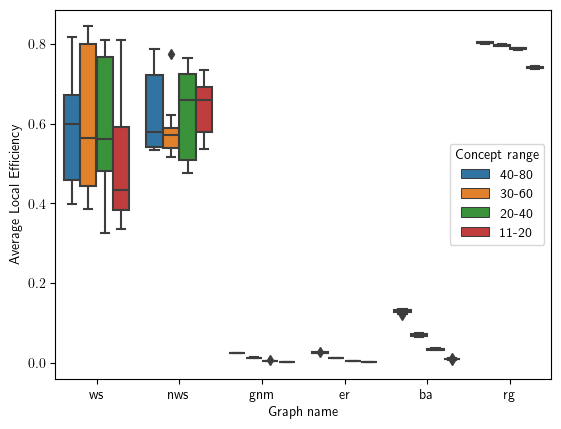

In [80]:
sns.boxplot(data=df_all, x="Graph name", y="Average Local Efficiency", hue="Concept range")

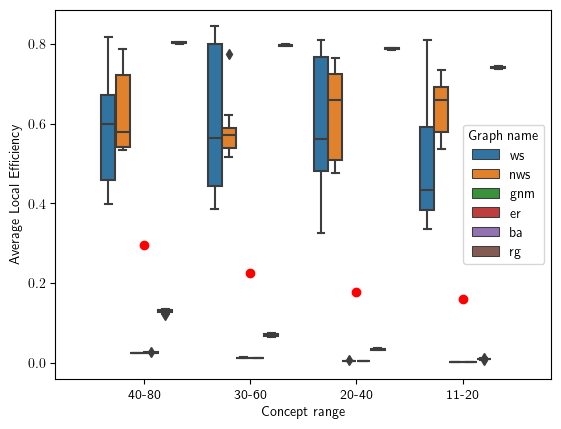

In [81]:
ax = sns.boxplot(data=df_all, x="Concept range", y="Average Local Efficiency", hue="Graph name")

for i in range(4):
    ax.scatter(i, dataframe_real.iloc[i, 7], color='red', zorder=5)

<Axes: xlabel='Graph name', ylabel='Average local clustering coefficient'>

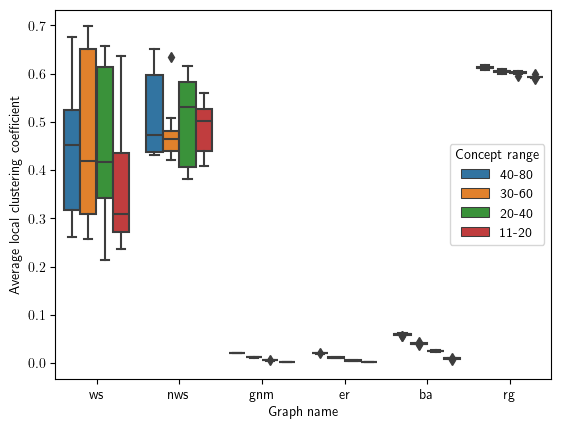

In [107]:
sns.boxplot(data=df_all, x="Graph name", y="Average local clustering coefficient", hue="Concept range")

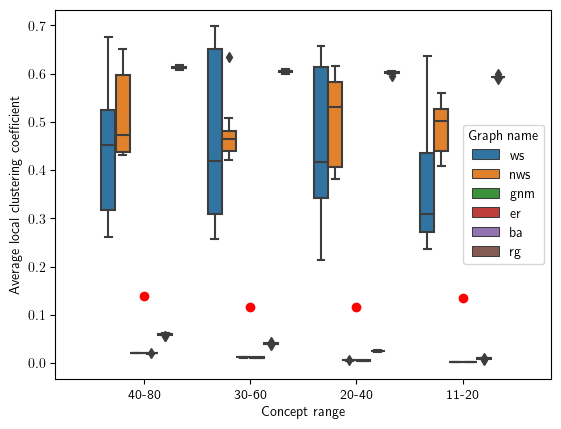

In [106]:
ax = sns.boxplot(data=df_all, x="Concept range", y="Average local clustering coefficient", hue="Graph name")

for i in range(4):
    ax.scatter(i, dataframe_real.iloc[i, 6], color='red', zorder=5)

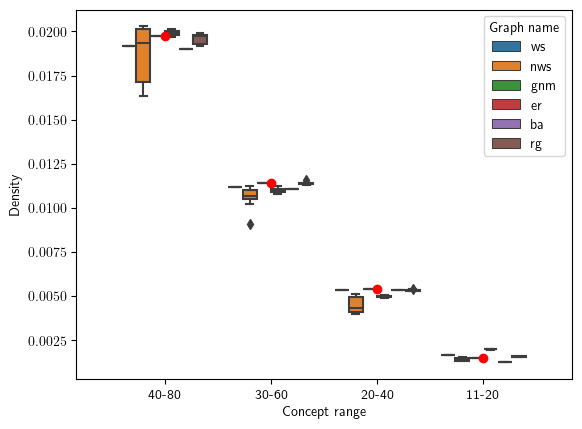

In [79]:
ax = sns.boxplot(data=df_all, x="Concept range", y="Density", hue="Graph name")

for i in range(4):
    ax.scatter(i, dataframe_real.iloc[i, 5], color='red', zorder=5)

In [54]:
print(dataframe_real)

  Graph name  Number of nodes  1-dim  2-dim  Number of edges   Density  \
0       Real             1149   4639    627            13021  0.019743   
1       Real             1614   6334     97            14853  0.011411   
2       Real             2623   8667     51            18496  0.005379   
3       Real             4785   7707      1            17456  0.001525   

   Average local clustering coefficient  Average Local Efficiency  Modularity  \
0                              0.139557                  0.295662    0.414614   
1                              0.116946                  0.225077    0.412802   
2                              0.115792                  0.178133    0.461906   
3                              0.135643                  0.160955    0.548521   

   Number of communities  Number of components  
0                     11                     3  
1                     14                     6  
2                     19                    12  
3                    108   

In [ ]:
random_graphs_30_60 = get_features(lists2, 3, 5, 0.3, 18, 14, 0.062)

All_means_30_60 = get_feature_mean_df(random_graphs_30_60, True)
print(All_means_30_60)

In [ ]:
random_graphs_30_60.append([G_list2[0]])

All_means_30_60 = get_feature_mean_df(random_graphs_30_60, True)
print(All_means_30_60)

In [ ]:
random_graphs_20_40 = get_features(lists3, 3, 5, 0.38, 14, 10, 0.042)
All_means_20_40 = get_feature_mean_df(random_graphs_20_40, True)
print(All_means_20_40)

In [ ]:
num = 10

original_graph_list1 = lists1[2]
edges_number = nx.number_of_edges(original_graph_list1[0])

double_graph_list1 = nmnd.double_swap_graph(num, 3, int(edges_number/5), int(edges_number/5)*5, original_graph_list1)


3

# Compare the persistence image

In [84]:
mylist_1 = get_mylist(lists1, 3, 10, True, 0.3, 22, 18, 0.082)
mylist_2 = get_mylist(lists2, 3, 10, True, 0.3, 18, 14, 0.062)
mylist_3 = get_mylist(lists3, 3, 10, True, 0.38, 14, 10, 0.042)
mylist_4 = get_mylist(lists4, 3, 10, True, 0.3, 8, 6, 0.0225)

[1149, 13021]
0.02
11
[1614, 14853]
0.011
9
[2623, 18496]
0.005
7
[4785, 17456]
0.002
3


In [85]:
distance_vector1=barcode_distance_vector(mylist_1)
print(1)

distance_vector2=barcode_distance_vector(mylist_2)
print(2)

distance_vector3=barcode_distance_vector(mylist_3)

distance_vector4=barcode_distance_vector(mylist_4)

1
2


In [86]:
combined_vectors = np.vstack((distance_vector1, distance_vector2, distance_vector3, distance_vector4))

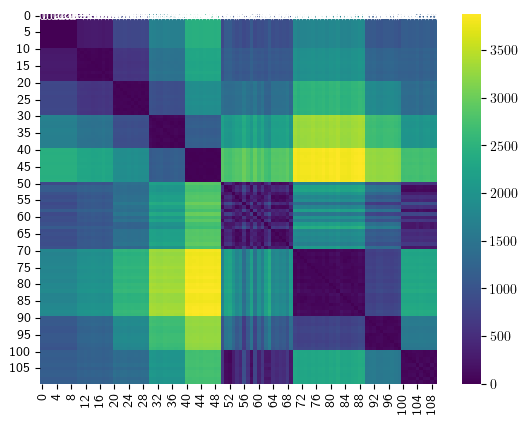

In [ ]:
# Create a heatmap
sns.heatmap(distance_matrix, cmap='viridis', annot=True)

# Show the plot
plt.show()

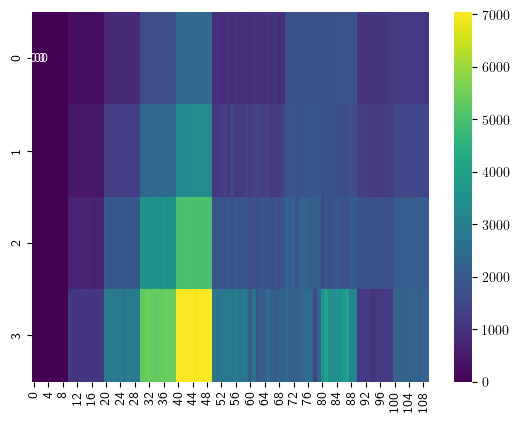

In [87]:
# Create a heatmap
sns.heatmap(combined_vectors, cmap='viridis', annot=True)

# Show the plot
plt.show()

In [ ]:
# Create a heatmap
sns.heatmap(distance_vector, cmap='viridis', annot=True)

# Show the plot
plt.show()

# MATRIX

In [ ]:
j = int(len(mylist)/10)

names_1 = ["Data"]
names_2 = ["local-edge-swap"]
names_3 = ["double-edge-swap"]
names_4 = ["Watts-Strogatz", "Newman-Watts-Strogatz", "G(n,m)", "G(n,p)", "Barabasi-Albert", "Random-geometric"]
names_5 = ["Watts-Strogatz_en", "Watts-Strogatz_8", "Watts-Strogatz_10", "Watts-Strogatz_12", "Watts-Strogatz_14"]

name = names_1  + names_4

origin = distance_matrix.iloc[0:9, 0:9]
or_sum = origin.values.sum()

for i in range(j):
    n = i*10
    n2 = n+9

    submatrix = distance_matrix.iloc[0:9, n:n2]

    # Calculate the sum of the elements in the submatrix
    submatrix_sum = submatrix.values.sum()
    subtract = submatrix_sum - or_sum
    print([name[i], subtract])

['Data', 0.0]
['Watts-Strogatz', 0.0]
['Newman-Watts-Strogatz', 0.0]
['G(n,m)', 0.0]
['G(n,p)', 0.0]
['Barabasi-Albert', 0.0]
['Random-geometric', 0.0]


# VECTOR

In [ ]:
j = int(len(mylist)/10)

origin = distance_vector.iloc[0, 0:9]
or_sum = origin.values.sum()

for i in range(j):
    n = i*10
    n2 = n+9

    subvector = distance_vector.iloc[0, n:n2]

    # Calculate the sum of the elements in the submatrix
    subvector_sum = subvector.values.sum()
    subtract = subvector_sum - or_sum
    print([name[i], subtract])

['Data', 0.0]
['Watts-Strogatz', 8846.297466598393]
['Newman-Watts-Strogatz', 8565.802507813905]
['G(n,m)', 15894.266603357382]
['G(n,p)', 15885.012948541802]
['Barabasi-Albert', 9718.20778071462]
['Random-geometric', 10138.711312347257]


# Combine the distance vector into a dataframe

In [98]:
Names = ["1/5 swap"]*10 + ["1/2 swap"]*10 + ["1 swap"]*10 + ["2 swap"]*10 + ["ws"]*10 + ["nws"]*10 + ["gnm"]*10 + ["er"]*10 +["ba"]*10 + ["rg"]* 10
group1 = ["40-80"] * 100
group2 = ["30-60"] * 100
group3 = ["20-40"] * 100
group4 = ["11-20"] * 100

distance1 = combined_vectors[0, 10:]
distance2 = combined_vectors[1, 10:]
distance3 = combined_vectors[2, 10:]
distance4 = combined_vectors[3, 10:]

In [99]:
df_dist_40_80 = pd.DataFrame({
            'Names': Names,
            'Group': group1,
            "Distance": distance1
        })

df_dist_30_60 = pd.DataFrame({
            'Names': Names,
            'Group': group2,
            "Distance": distance2
        })

df_dist_20_40 = pd.DataFrame({
            'Names': Names,
            'Group': group3,
            "Distance": distance3
        })

df_dist_11_20 = pd.DataFrame({
            'Names': Names,
            'Group': group4,
            "Distance": distance4
        })

df_dist_all = pd.concat([df_dist_40_80, df_dist_30_60, df_dist_20_40, df_dist_11_20], axis=0)
print(df_dist_all)

       Names  Group     Distance
0   1/5 swap  40-80   268.514721
1   1/5 swap  40-80   285.099552
2   1/5 swap  40-80   273.225699
3   1/5 swap  40-80   234.505097
4   1/5 swap  40-80   272.403149
..       ...    ...          ...
95        rg  11-20  2264.162901
96        rg  11-20  2229.564364
97        rg  11-20  2128.801502
98        rg  11-20  2248.561101
99        rg  11-20  2158.858837

[400 rows x 3 columns]


<Axes: xlabel='Group', ylabel='Distance'>

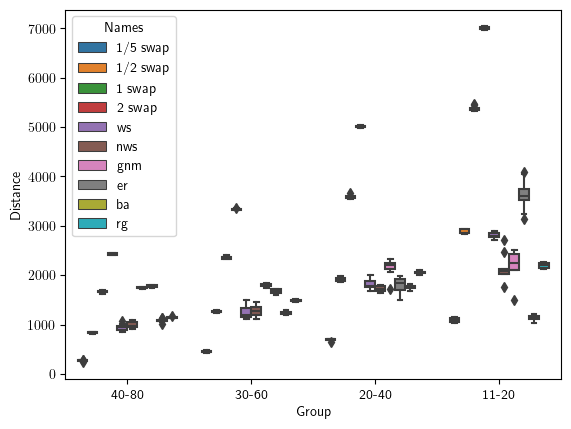

In [105]:
filtered_df = df_dist_all[df_dist_all['Names'].isin(['1/5 swap', '1/2 swap', '1 swap', '2 swap'])]
sns.boxplot(data=df_dist_all, x="Group", y="Distance", hue="Names")